# Relationship between Dataset Size and Neural Network Accuracy for Marine Mammal Acoustic Classification

This is the code I wrote for my final project in the course BIOEE 1610: Introduction to Ecology at Cornell University. The project entailed me creating a small research project and writing up my results as a formal scientific paper. 

Conservation efforts for threatened marine mammals are uninformed due to data scarcity. Monitoring marine mammals to estimate abundances is a non-trivial task due to species rarity and large spatial distributions. Passive Acoustic Monitoring (PAM) is gaining traction with the use of machine learning. Convolutional Neural Networks (CNNs) effectively classify sounds through spectrogram analysis, but require large datasets, a rarity in marine mammal science. Transfer learning, a method to reduce the number of datapoints needed, was used to investigate the effect of dataset size on the accuracy of a CNN trained to distinguish between two marine mammal species by sound. The results show a weak, positive correlation between dataset size and model accuracy, with the regression line having r2=0.0945 and a slope of 0.0003. Only 20 datapoints were necessary to achieve 98% accuracy. Transfer learning enables accurate PAM systems with minimal initial data, allowing for larger studies that better inform conservation. 

# Dependencies

In [ ]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#for loading and visualizing audio files
import librosa
import librosa.display
import wave

#to play audio
import IPython.display as ipd

# for image splitting and resizing
from split_image import split_image
from PIL import Image

# for ML 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# random
import random

# Spectrogram Creation

### To experiment with the effects of reducing the dataset size, we randomly drop a number of files

In [16]:
audio_fpath = "datasets/my-set/audio/LFP/"
audio_clips = [f for f in os.listdir(audio_fpath) if not f.startswith('.')]
NUM_TO_DROP = 30

print("No. of .wav files in audio folder = ",len(audio_clips))

for i in range(NUM_TO_DROP):
    audio_clips.pop(random.randrange(len(audio_clips))) 

print("No. of .wav files in sample = ",len(audio_clips))

No. of .wav files in audio folder =  54
No. of .wav files in sample =  24


81600


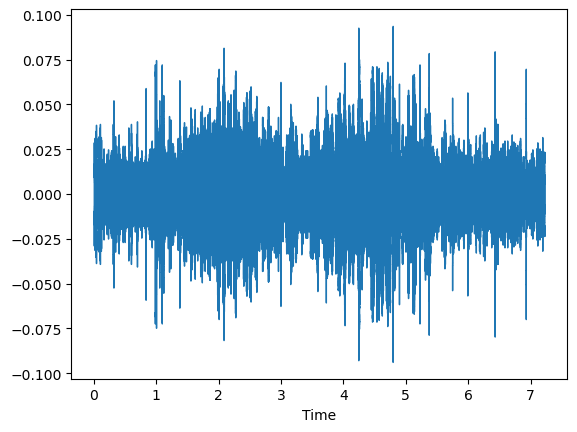

In [20]:
# Examining a waveform 
s = librosa.get_samplerate(audio_fpath+'7500402F.wav')
print(s)

x, sr = librosa.load(audio_fpath+'7500402F.wav', sr=s)
librosa.display.waveshow(x)

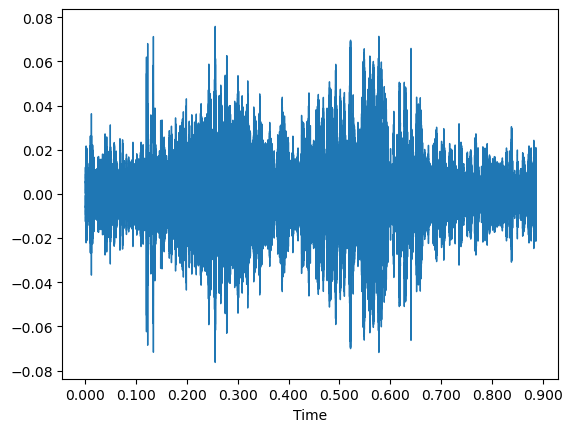

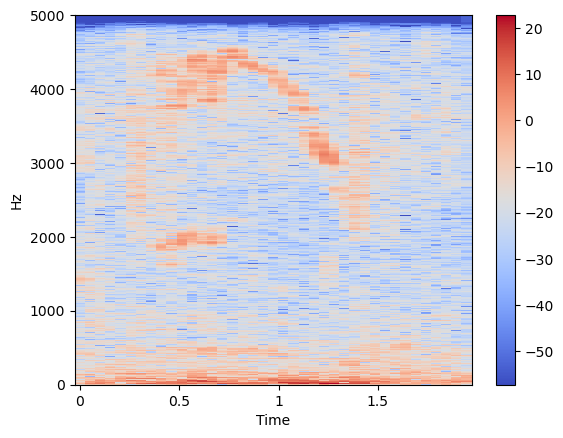

In [23]:
# generating test spectrogram
x, sr = librosa.load(audio_fpath+'7500402F.wav', sr=10000)
librosa.display.waveshow(x)

#generate spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure()
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [24]:
IMG_PATH = 'datasets/my-set/imgs/LFS/'
# function to automate spectrogram creation
def create_spectrogram(file_name):
    # load file at specified sample rate
    x, sr = librosa.load(audio_fpath+file_name, sr=10000)
    
    # Plot the figure and then save it
    X = librosa.stft(x) # note: short term fourier transform, which is different than used in paper
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure()
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    librosa.display.specshow(Xdb, sr=sr) # NO AXES or color bar
    plt.savefig(IMG_PATH + file_name[:-3]+'jpg', bbox_inches='tight', pad_inches=0)
    
    # sub segment the image
    split_image(IMG_PATH + file_name[:-3]+'jpg', 1, 99, False, False, output_dir=IMG_PATH+'segments/',should_quiet=True)
    print('done')

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


/Applications/anaconda3/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1000
  warnings.warn(


done
done
done
done
done
done
done
done


/var/folders/lv/0w01hdjd20g_v4q9k2bpnpgm0000gn/T/ipykernel_53004/1155296876.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


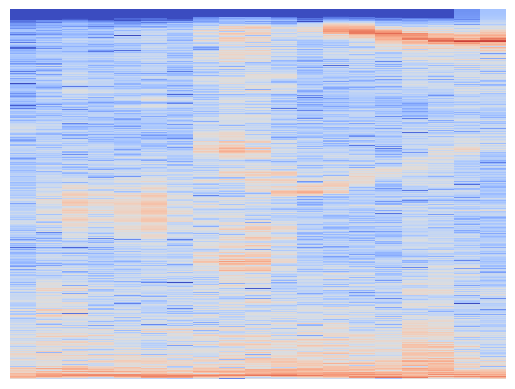

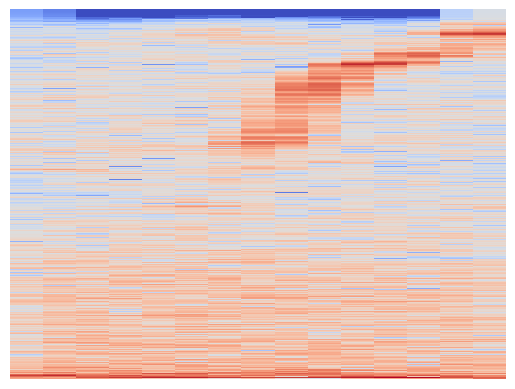

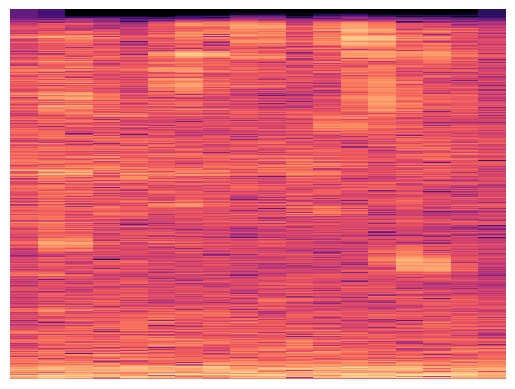

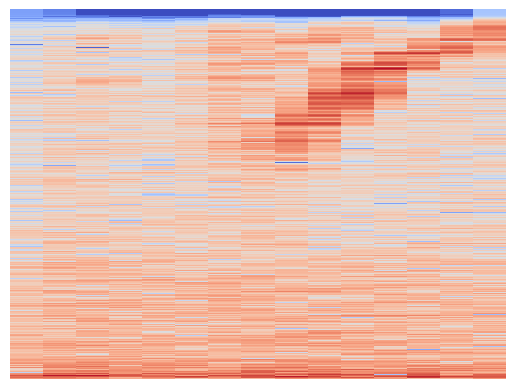

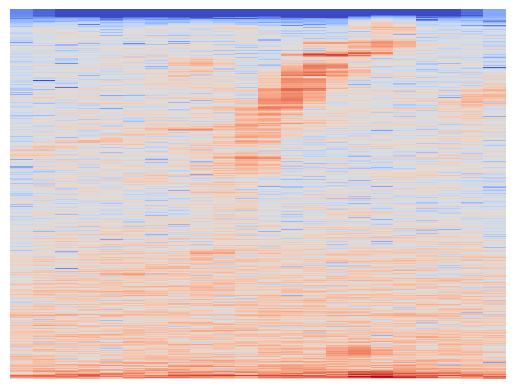

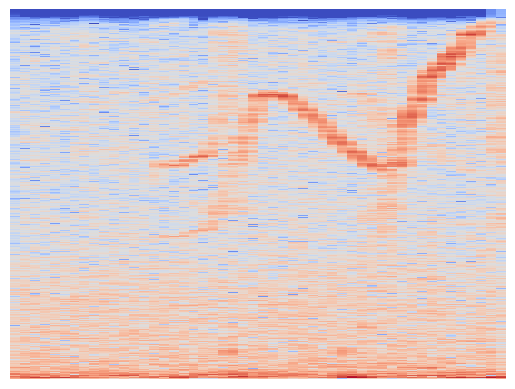

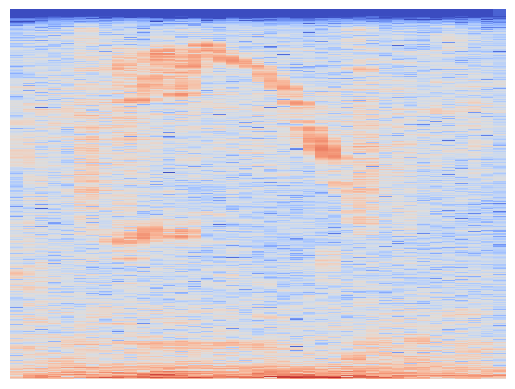

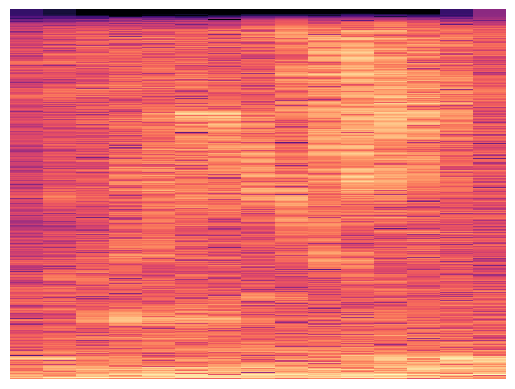

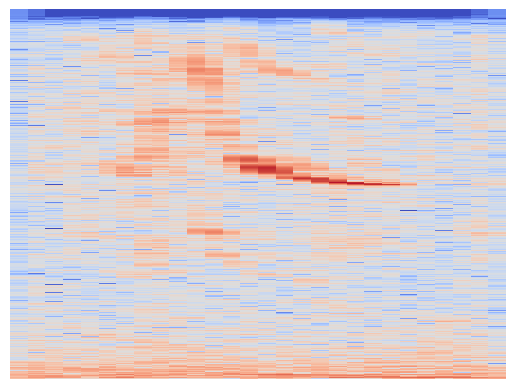

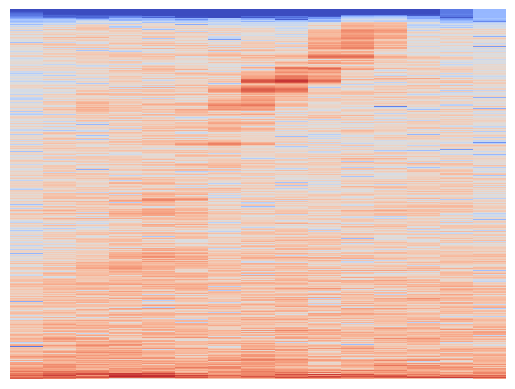

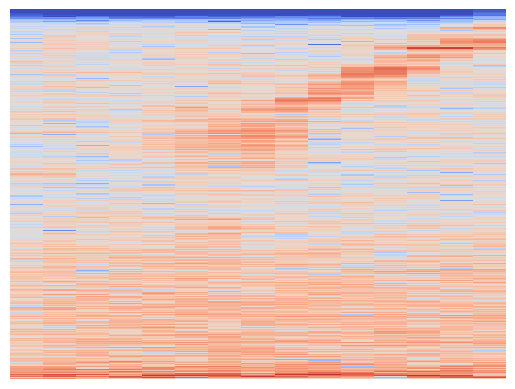

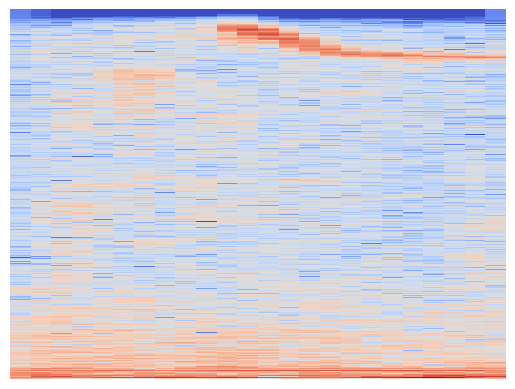

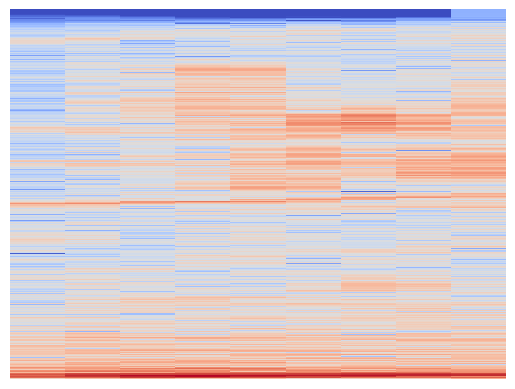

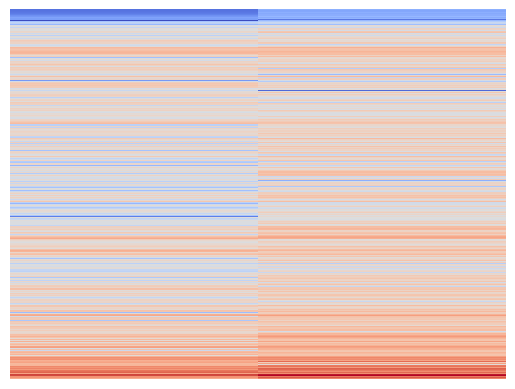

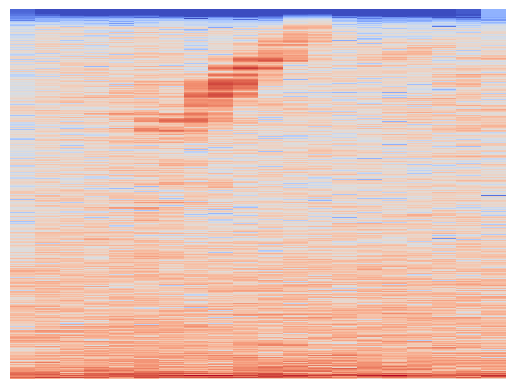

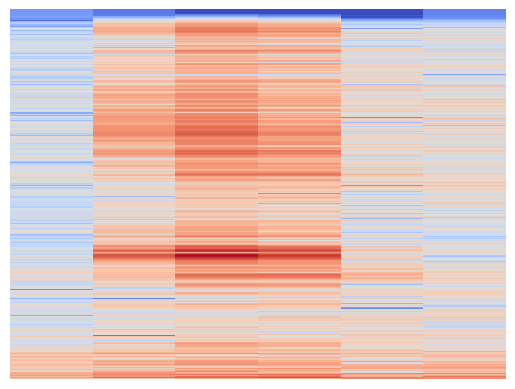

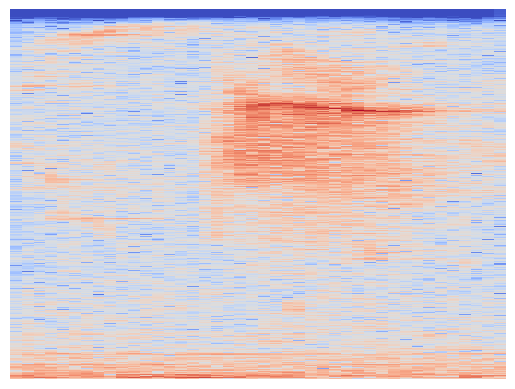

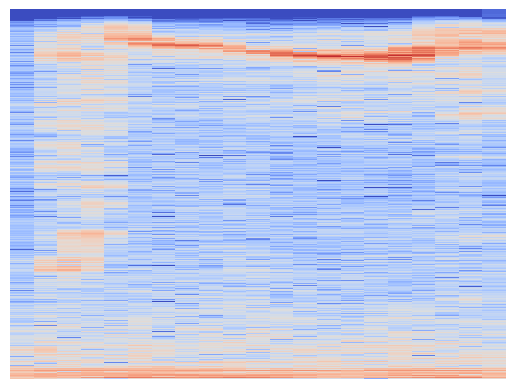

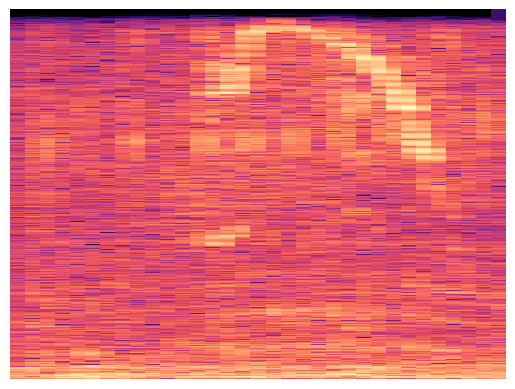

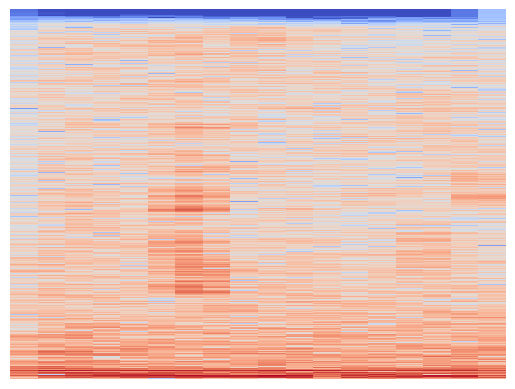

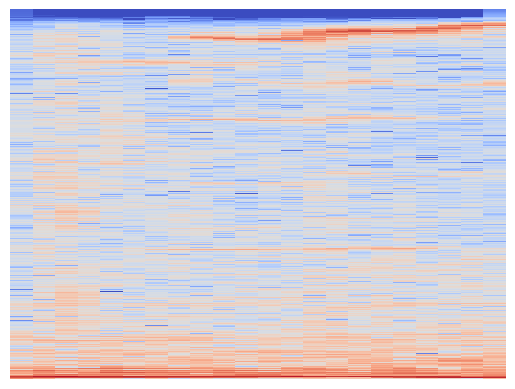

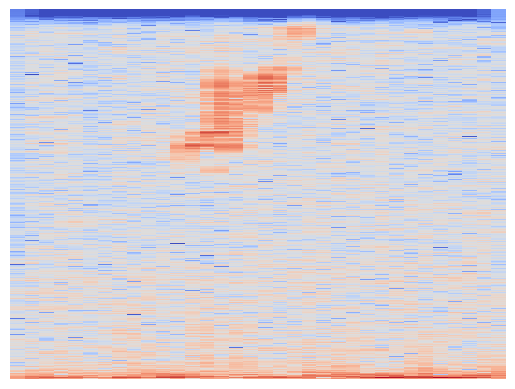

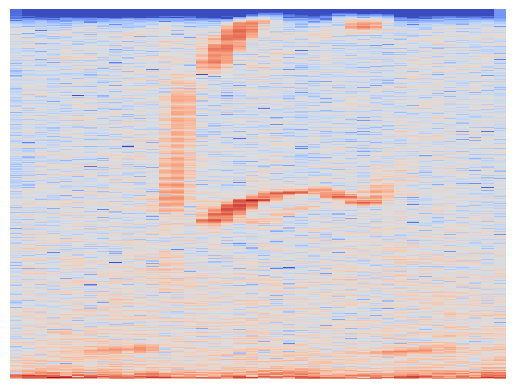

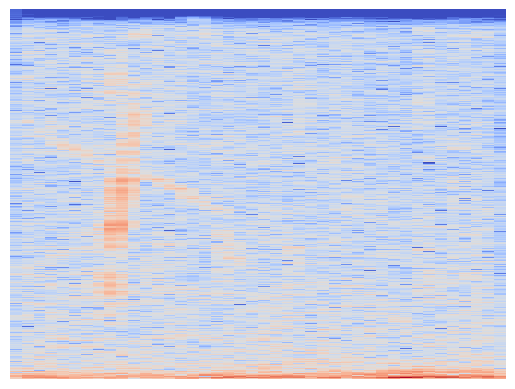

In [143]:
# do spectrograms and segmentation for all clips
for clip in audio_clips:
    create_spectrogram(clip)

In [144]:
# resize everything
SEGMENT_FOLDER = IMG_PATH + 'segments/'
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
SIZE = (227, 227)

for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment
    
    # only take segments from the middle (cut tails)
    number = int(segment[segment.find('_')+1:segment.find('.')])
    if (number < 25 or number > 75):
        os.remove(file_path) 
    else:
        # resize immages that aren't at the tails
        im = Image.open(file_path)  
        im = im.resize(SIZE)
        im.save(file_path)
    




# Create Dataset

## for Harp seal

In [6]:
# create new dataset
IMG_PATH = 'datasets/my-set/imgs/HS/'
SEGMENT_FOLDER = IMG_PATH + 'segments/'
dataset = pd.DataFrame(columns=['img', 'class'])

#add img to dataset for harp seal (class = 0)
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment

    image = Image.open(file_path)
    image = np.asarray(image)

    dataset.loc[len(dataset.index)] = [image, 0] 

## For long-finned whale

In [7]:
IMG_PATH = 'datasets/my-set/imgs/LFS/'
SEGMENT_FOLDER = IMG_PATH + 'segments/'

#add img to dataset for harp seal (class = 0)
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment

    image = Image.open(file_path)
    image = np.asarray(image)

    dataset.loc[len(dataset.index)] = [image, 1] 

## Train Test Split

In [147]:
X = dataset['img'].to_numpy()
y = dataset['class'].to_numpy()

X = np.stack(X)
X = np.asarray(X, dtype='float32')

y = np.stack(y)
y = np.asarray(y, dtype='float32')

In [148]:
X.shape

(2040, 227, 227, 3)

In [149]:
y.shape

(2040,)

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Build Model

In [125]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (227, 227, 3))
for layer in model.layers[:17]:
    layer.trainable = False

#Adding custom Layers 

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation="relu")(x)

predictions = Dense(1, activation="sigmoid")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=["accuracy"])

In [126]:
model_final.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [127]:
history = model_final.fit(X_train, y_train,epochs=5,batch_size=128,verbose=True,validation_data=(X_test, y_test))

Epoch 1/5
7/7 [==============================] - 68s 10s/step - loss: 7.1290 - accuracy: 0.6225 - val_loss: 0.8658 - val_accuracy: 0.6225
Epoch 2/5
7/7 [==============================] - 67s 10s/step - loss: 0.2702 - accuracy: 0.8946 - val_loss: 0.1811 - val_accuracy: 0.9363
Epoch 3/5
7/7 [==============================] - 67s 10s/step - loss: 0.0629 - accuracy: 0.9828 - val_loss: 0.0813 - val_accuracy: 0.9804
Epoch 4/5
7/7 [==============================] - 67s 10s/step - loss: 0.0724 - accuracy: 0.9730 - val_loss: 0.2815 - val_accuracy: 0.9657
Epoch 5/5
7/7 [==============================] - 67s 10s/step - loss: 0.0376 - accuracy: 0.9804 - val_loss: 0.0221 - val_accuracy: 0.9853


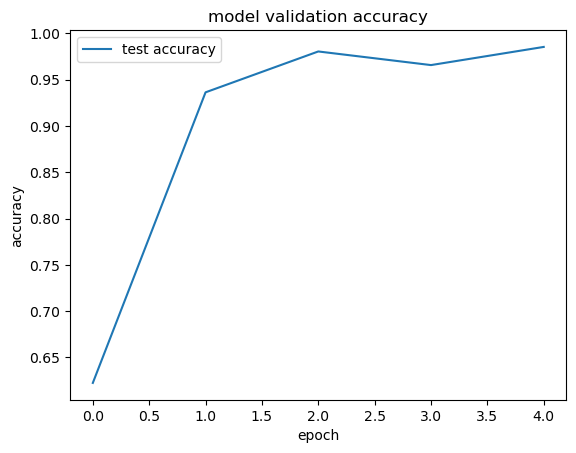

In [128]:
# summarize history for loss
plt.plot(history.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test accuracy'], loc='upper left')
plt.show()

In [129]:
y_pred = model_final.predict(X_test)
y_pred = (np.rint(y_pred)).astype(int)

7/7 [==============================] - 13s 2s/step


In [130]:
cf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)

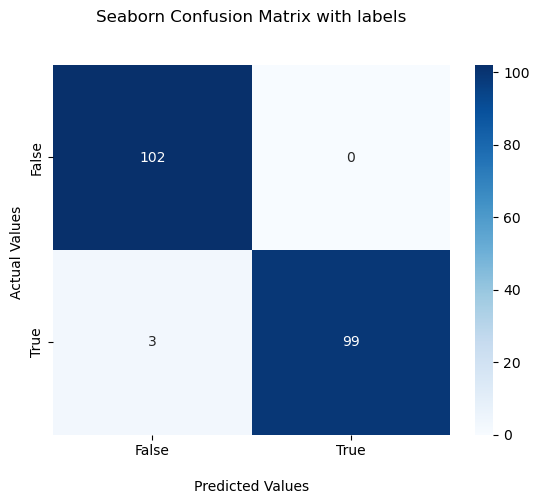

In [131]:
#Plot the confusion matrix.
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt=',d')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Splitting the data by train and test before creating subspectrograms
This prevents overfitting, as many of the subspectrograms in the train and test dataset were too similar in the previous method (because they were part of the same original spectrogram/sound bite). Splitting beforehand insures that subspectrograms are not from the same original file)

In [118]:
audio_fpath = "datasets/my-set/audio/HS/"
audio_clips = [f for f in os.listdir(audio_fpath) if not f.startswith('.')]
NUM_TO_DROP = 40

print("No. of .wav files in audio folder = ",len(audio_clips))

for i in range(NUM_TO_DROP):
    audio_clips.pop(random.randrange(len(audio_clips))) 

print("No. of .wav files in sample = ",len(audio_clips))

No. of .wav files in audio folder =  46
No. of .wav files in sample =  6


done
done
done
done
done
done


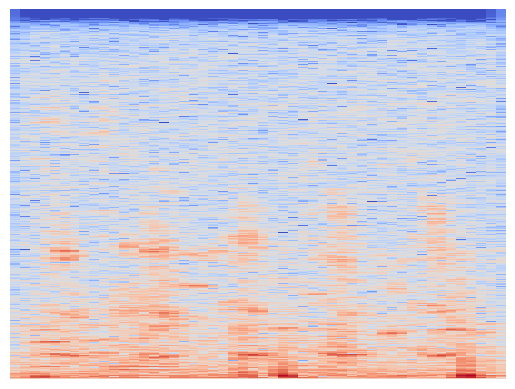

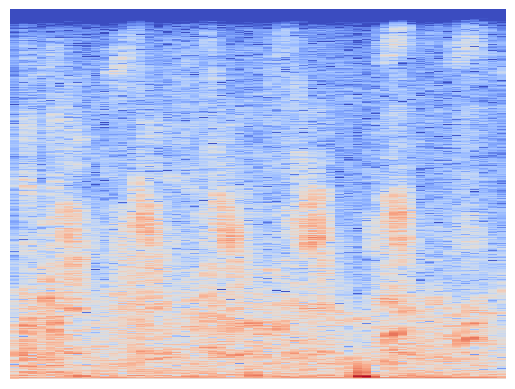

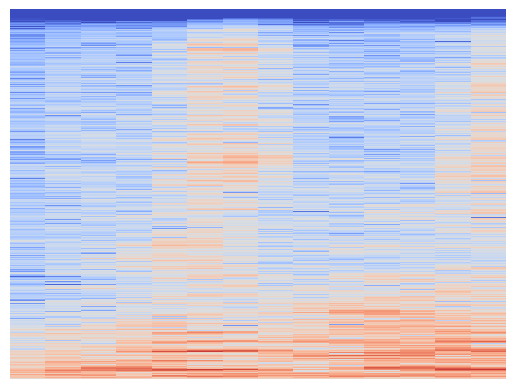

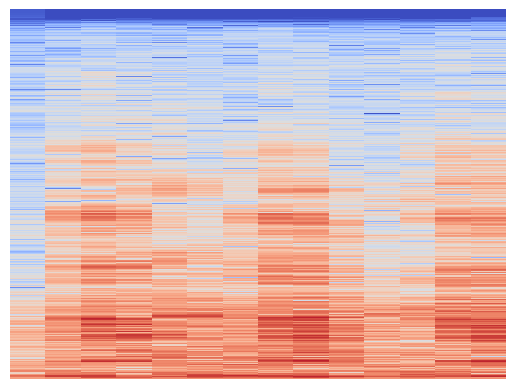

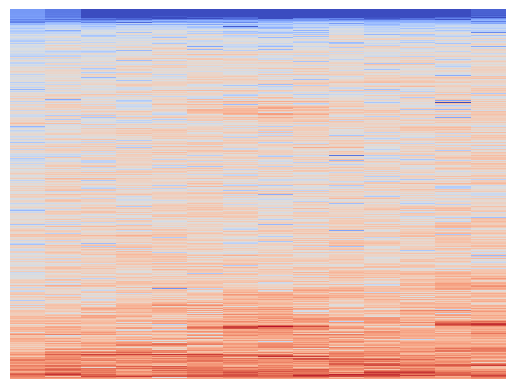

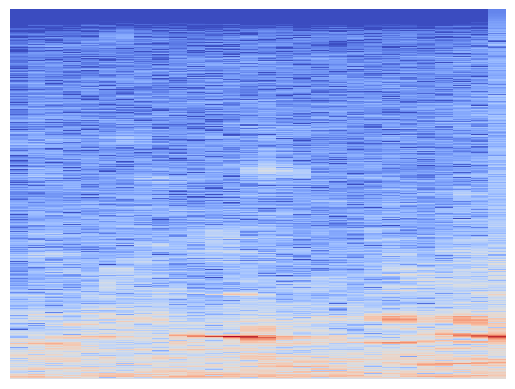

In [119]:
IMG_PATH = 'datasets/my-set/imgs/HS/'
AMT_TEST = 0.3

def create_spectrogram(file_name):
    # load file at specified sample rate
    x, sr = librosa.load(audio_fpath+file_name, sr=10000)
    
    # Plot the figure and then save it
    X = librosa.stft(x) # note: short term fourier transform, which is different than used in paper
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure()
    for pos in ['right', 'top', 'bottom', 'left']: 
        plt.gca().spines[pos].set_visible(False) 
    librosa.display.specshow(Xdb, sr=sr) # NO AXES or color bar
    plt.savefig(IMG_PATH + file_name[:-3]+'jpg', bbox_inches='tight', pad_inches=0)
    
    # sub segment the image in train or test folder
    if random.random() < AMT_TEST:
        split_image(IMG_PATH + file_name[:-3]+'jpg', 1, 99, False, False, output_dir=IMG_PATH+'segments/test',should_quiet=True)
    else:
        split_image(IMG_PATH + file_name[:-3]+'jpg', 1, 99, False, False, output_dir=IMG_PATH+'segments/train',should_quiet=True)
    print('done')
    
# do spectrograms and segmentation for all clips
for clip in audio_clips:
    create_spectrogram(clip)

In [122]:
# resize everything
SEGMENT_FOLDER = IMG_PATH + 'segments/train/'
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
SIZE = (227, 227)

for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment
    
    # only take segments from the middle (cut tails)
    number = int(segment[segment.find('_')+1:segment.find('.')])
    if (number < 25 or number > 75):
        os.remove(file_path) 
    else:
        # resize immages that aren't at the tails
        im = Image.open(file_path)  
        im = im.resize(SIZE)
        im.save(file_path)
        
# resize everything
SEGMENT_FOLDER = IMG_PATH + 'segments/test/'
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
SIZE = (227, 227)

for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment
    
    # only take segments from the middle (cut tails)
    number = int(segment[segment.find('_')+1:segment.find('.')])
    if (number < 25 or number > 75):
        os.remove(file_path) 
    else:
        # resize immages that aren't at the tails
        im = Image.open(file_path)  
        im = im.resize(SIZE)
        im.save(file_path)

In [123]:
# create new train dataset for harp seal
IMG_PATH = 'datasets/my-set/imgs/HS/'
SEGMENT_FOLDER = IMG_PATH + 'segments/train/'
train = pd.DataFrame(columns=['img', 'class'])

#add img to dataset for harp seal (class = 0)
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment

    image = Image.open(file_path)
    image = np.asarray(image)

    train.loc[len(train.index)] = [image, 0] 

# create new train dataset for LFP
IMG_PATH = 'datasets/my-set/imgs/LFP/'
SEGMENT_FOLDER = IMG_PATH + 'segments/train/'

#add img to dataset for harp seal (class = 0)
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment

    image = Image.open(file_path)
    image = np.asarray(image)

    train.loc[len(train.index)] = [image, 1] 
    
# create new test dataset for harp seal
IMG_PATH = 'datasets/my-set/imgs/HS/'
SEGMENT_FOLDER = IMG_PATH + 'segments/test/'
test = pd.DataFrame(columns=['img', 'class'])

#add img to dataset for harp seal (class = 0)
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment

    image = Image.open(file_path)
    image = np.asarray(image)

    test.loc[len(test.index)] = [image, 0] 
    

# create new test dataset for LFP
IMG_PATH = 'datasets/my-set/imgs/LFP/'
SEGMENT_FOLDER = IMG_PATH + 'segments/test/'

#add img to dataset for harp seal (class = 0)
segment_list = [f for f in os.listdir(SEGMENT_FOLDER) if not f.startswith('.')]
for segment in segment_list:
    file_path = SEGMENT_FOLDER + segment

    image = Image.open(file_path)
    image = np.asarray(image)

    test.loc[len(test.index)] = [image, 1] 

In [124]:
X_train = train['img'].to_numpy()
y_train = train['class'].to_numpy()
X_test = test['img'].to_numpy()
y_test = test['class'].to_numpy()

X_train = np.stack(X_train)
X_train = np.asarray(X_train, dtype='float32')
y_train = np.stack(y_train)
#y = np.asarray(y, dtype='float32')

X_test = np.stack(X_test)
X_test = np.asarray(X_test, dtype='float32')
y_test = np.stack(y_test)
#y = np.asarray(y, dtype='float32')